# Hierarchical Material Clustering
Data.csv is available on github.
Run the subsequent cell to generate the following:

1. df (a dataframe containing ~430 materials)
2. original_df (a dataframe containing ~640 materials)
3. steel_df (a dataframe containing ~160 steels only)

It is recommended to export the generated dendrogram figure as a vector image to view elsewhere if plotting >200 materials.

In [192]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data_pared.csv')
df = df.drop(columns=['Desc', 'HV','pH','Bhn'])
df['Material'] = df.apply(lambda row: row['Material'] + f" ({row['Heat treatment']})" if row['Heat treatment'] else row['Material'], axis=1)
df.dropna(axis=1, how='any', inplace=True)
df_copy = df.copy()
original_df = df.copy()

key_list = ['Copper Alloy', 'High-Copper Alloy', 'Red brass', 'Semi-red Brass', 
            'Yellow Brass', 'Manganese Bronze', 'Silicon Brass', 'Silicon Bronze', 
            'Tin Bronze', 'Leaded Tin Bronze','High Leaded Tin Bronze',
            'Nickel-Tin Bronze', 'Aluminum Bronze', 'Copper-Nickel', 'Nickel Silver', 
            'Low brass', 'Cartridge brass', 'Yellow brass', 'Low-leaded brass', 
            'High-leaded brass', 'Malleable cast iron','Nodular cast iron',
            'Grey cast iron', 'Magnesium Alloy']

for index, row in df_copy[::-1].iterrows():
    if any(key in row['Material'] for key in key_list):
        df_copy = df_copy.drop(index)
        
def collapse(key_list, name_list):
    collapsed_df = pd.DataFrame()
    k = 0
    for key in key_list:
        filtered_df = df[df['Material'].str.contains(key)]
        numeric_cols = filtered_df.select_dtypes(include=[np.number])
        mean_row = numeric_cols.mean()
        mean_row['Material'] = name_list[k]
        k = k+1
        collapsed_df = pd.concat([collapsed_df, pd.DataFrame([mean_row])], ignore_index=True)
    return collapsed_df

collapsed_df = collapse(key_list, key_list)
df = pd.concat([df_copy,collapsed_df], ignore_index=True)

def normalize_column(column):
    min_col = column.min()
    max_col = column.max()
    normalized_col = -1 + ((column - min_col) * 2) / (max_col - min_col)
    return normalized_col

for column in df.select_dtypes(include=[np.number]).columns:
    df[column] = normalize_column(df[column])
    
steel_df = df[df['Material'].str.contains('Steel', case=False, na=False)]
#steel_df['Material'] = steel_df['Material'].str.replace('.', '', regex=False)

import numpy as np
import scipy.spatial.distance as distance
from scipy._lib._array_api import array_namespace, as_xparray, copy
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import optimal_leaf_ordering
from scipy.cluster import _hierarchy 
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

METHODS = {'single': 0, 'complete': 1, 'average': 2,'ward': 5, 'weighted': 6}

# The algorithm 

def agglom(y, labels=None, method='average', metric='euclidean', plots=True, dend=True,opt=False):
    
    original_y = y
    xp = array_namespace(y)
    y = as_xparray(y, order='C', dtype=xp.float64, xp=xp)
    y = distance.pdist(y, metric)
    y = xp.asarray(y)
    n = int(distance.num_obs_y(y))
    method_code = METHODS[method]
    y = np.asarray(y)
    

    if method == 'single':
        result = _hierarchy.mst_single_linkage(y, n)
    elif method in ['complete', 'average', 'weighted', 'ward']:
        result = _hierarchy.nn_chain(y, n, method_code)
    else:
        result = _hierarchy.fast_linkage(y, n, method_code)
    result = xp.asarray(result)
    
    result = optimal_leaf_ordering(result, y)
    sil_array = []
    
    for i in range(1, 20):  
        num_clusters = i
        clusters = fcluster(result, t=num_clusters, criterion='maxclust')
        unique_clusters = np.unique(clusters)
        if len(unique_clusters) > 1:  
            silhouette_avg = silhouette_score(original_y, clusters)
            sil_array.append(silhouette_avg)
        
    if opt:
        opt_clusters = 1.5
    else:
        opt_clusters = 3
    sil_array.append(opt_clusters)
    
    if plots:
        plt.plot(sil_array[:18], 'bx-')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Index')
        plt.title('Silhouette Index vs. # of Clusters')
        plt.show()
    
    if dend:
        fig = plt.figure(figsize=(10, 20))
        if labels is None:
            dn = dendrogram(result, orientation='right', color_threshold=1.5)
        else:
            dn = dendrogram(result, labels=labels, orientation='right', color_threshold=0.2)
        
        ax = plt.gca() 
        ax.spines['top'].set_visible(False)    
        ax.spines['bottom'].set_visible(False) 
        ax.spines['left'].set_visible(False) 
        ax.spines['right'].set_visible(False)  
        plt.xticks([])
        
        # Save figure as SVG
        
        #plt.savefig('savedSVG.svg')
        
        plt.show()
        
        # Print Labels to a text file
        
        #labelsfile = dn["ivl"]
        #reversed_array = labelsfile[::-1]
        
        #with open("labels.txt", 'w') as file:
        #    for item in reversed_array:
        #        file.write(f"{item}\n")

    return result, sil_array

# Plotting
Run the subsequent cells to generate dendrograms for steels only, or the entire dataset.

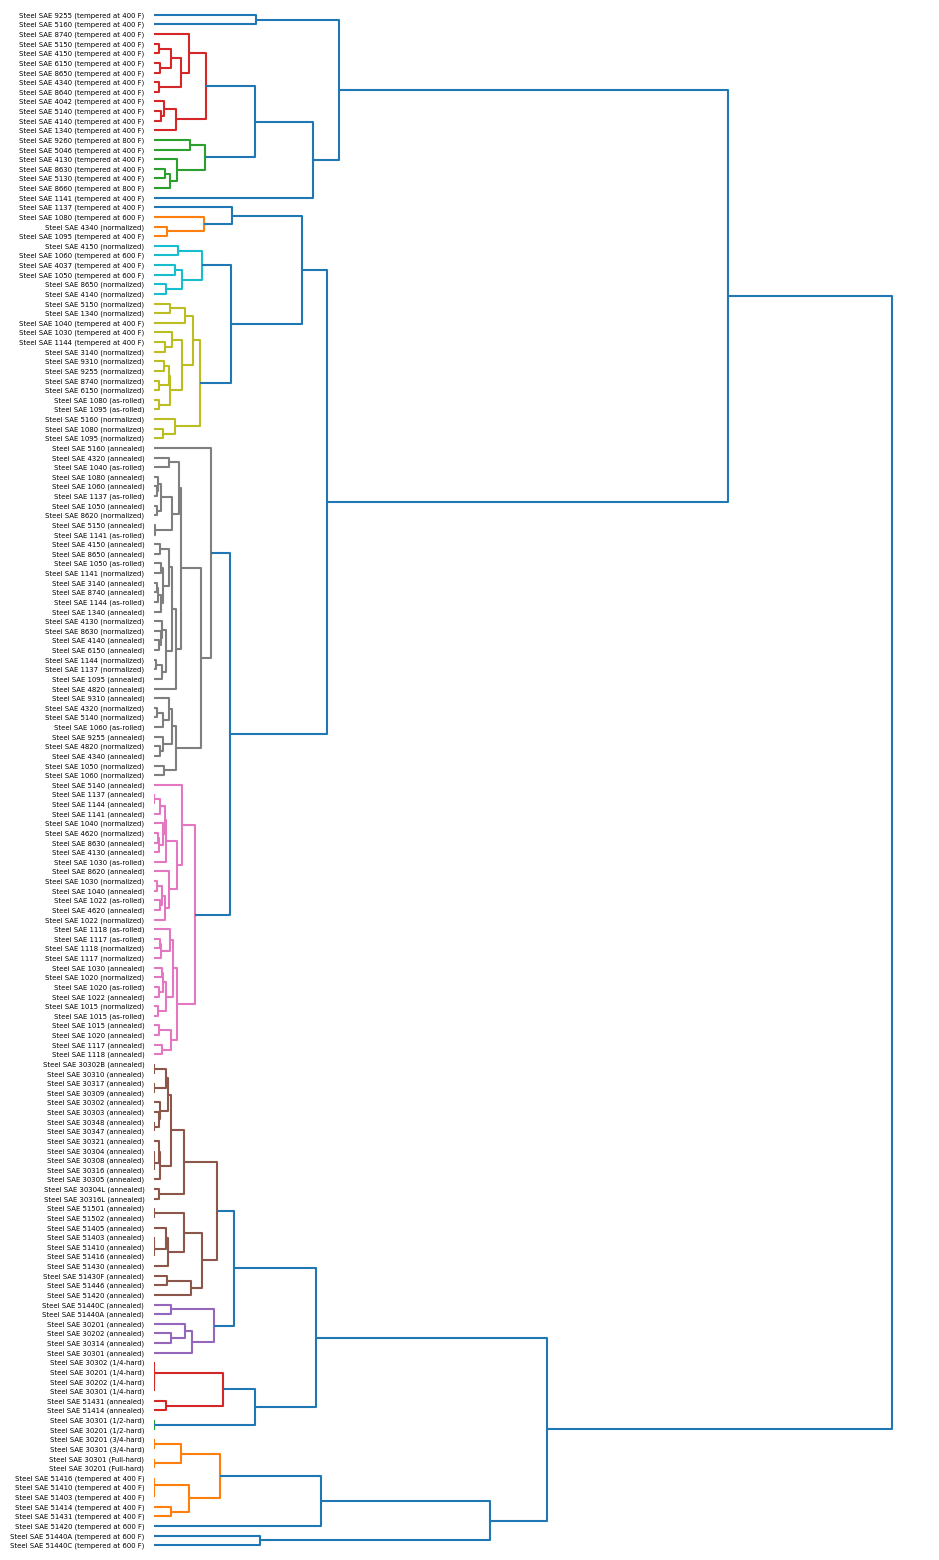

In [194]:
numeric_df = steel_df.select_dtypes(include=[np.number])

matrix = numeric_df.values

labels = steel_df['Material'].to_numpy()

result, sils_single = agglom(matrix, labels=labels, method = 'average',plots=False)

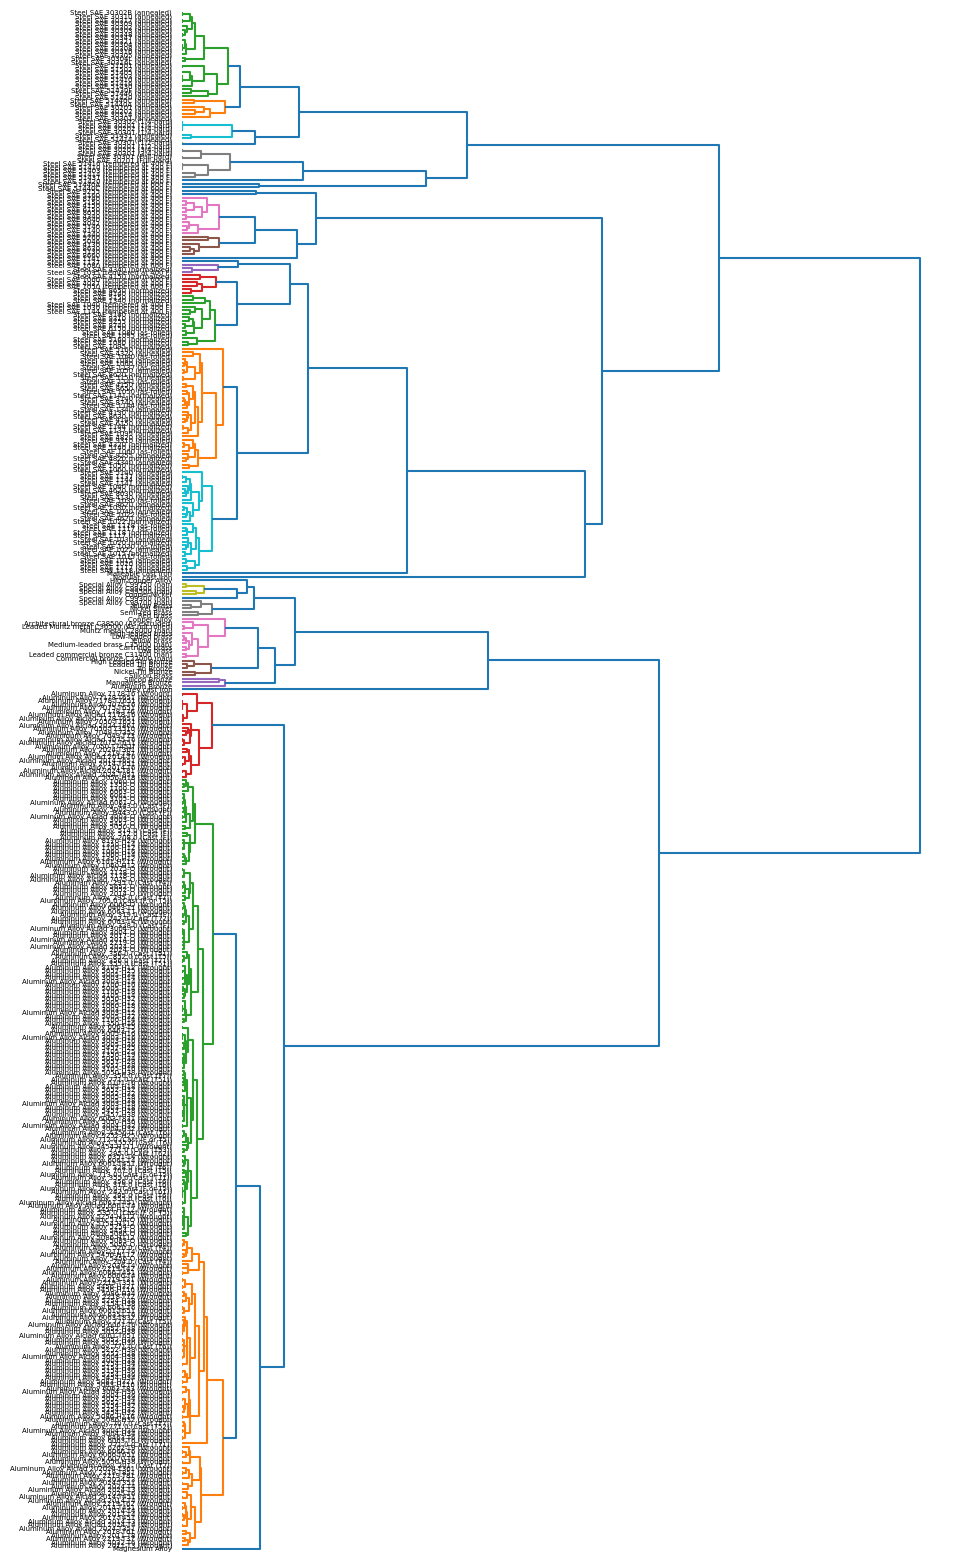

In [198]:
numeric_df = df.select_dtypes(include=[np.number])

matrix = numeric_df.values

labels = df['Material'].to_numpy()

result, sils_single = agglom(matrix, labels=labels, method = 'average',plots=False)

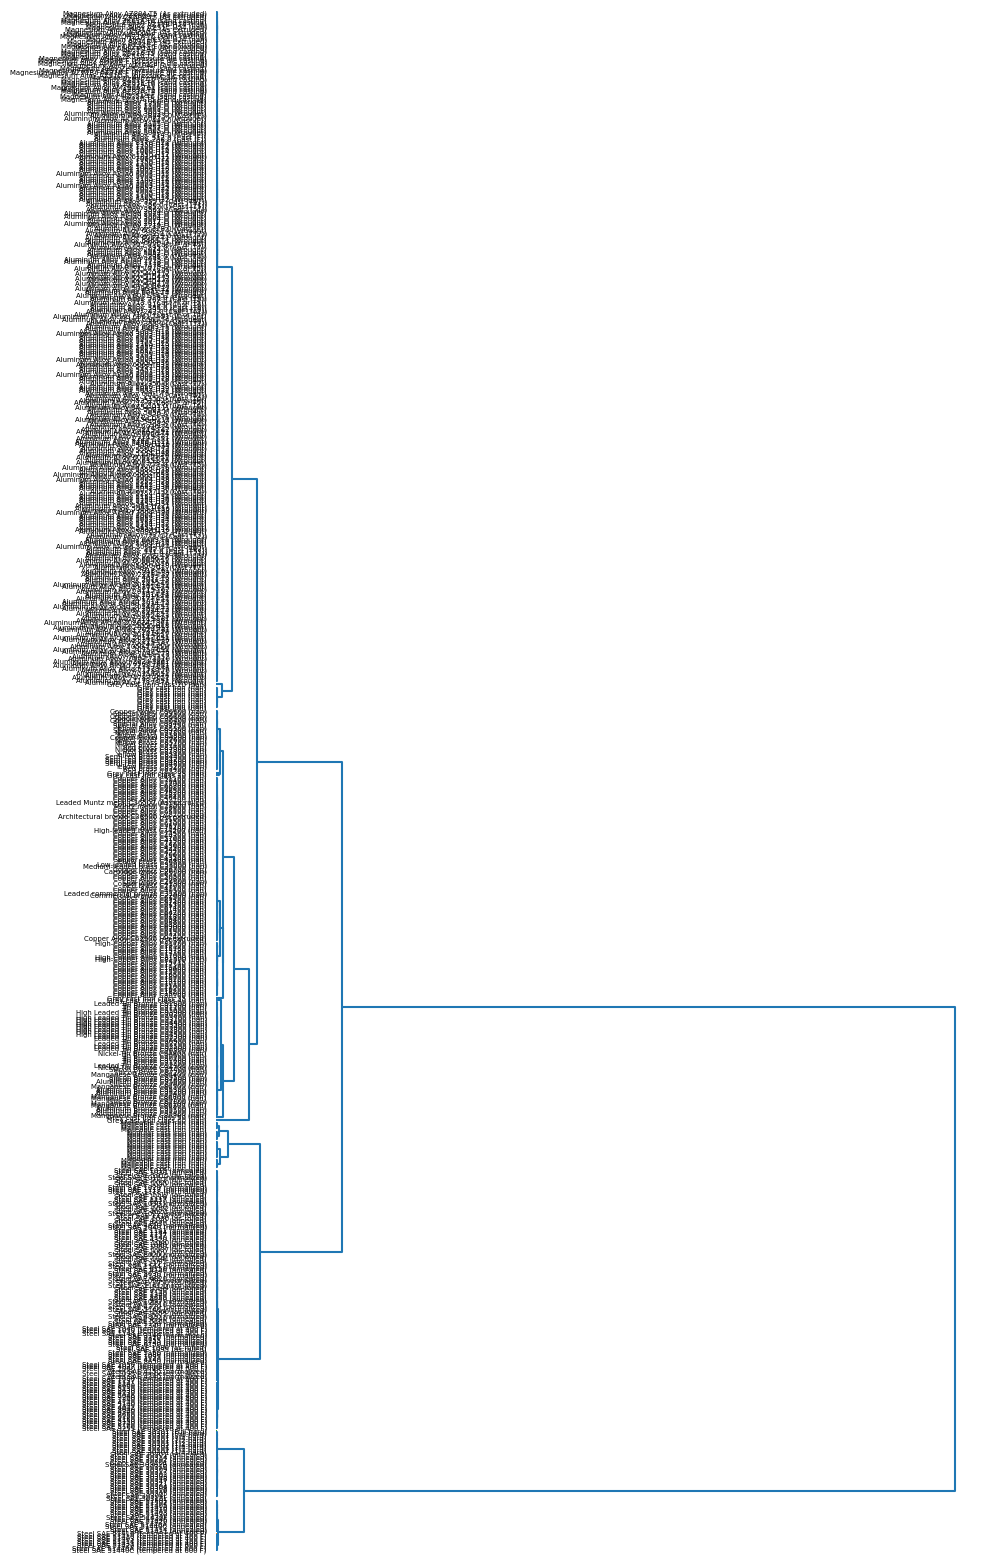

In [197]:
numeric_df = original_df.select_dtypes(include=[np.number])

matrix = numeric_df.values

labels = original_df['Material'].to_numpy()

result, sils_single = agglom(matrix, labels=labels, method = 'average',plots=False)